<center>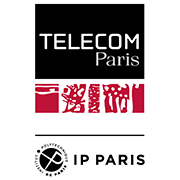</center>

<h1><center><strong><font color="green">IGR204 Visualisation<br/>Projet Baby name</font></strong></center></h1>

<h3><center><font color="blue"><strong>Groupe U</strong></font></center></h3>

<center>
<h3> Project student</h3>
<a>Nicolas Allègre</a> <email>nicolas.allegre@telecom-paris.fr</email><br>
<a>Romain Donné</a> <email>romain.donne@telecom-paris.fr</email><br>
<a>Aude De Fornel</a> <email>aude.defornel@telecom-paris.fr</email><br>
<a>François-Xavier Morel</a> <email>francois-xavier.morel@telecom-paris.fr</email><br>
<a>Camille Ishac</a> <email>camille.ishac@telecom-paris.fr</email><br>

<br/>
Année 2024-2025
</center>

------------------------

### Table of Contents

* [Chapter 0 Préparation](#0---préparation)
* [Chapter 4 - AMR](#4---amr)

<!-- <a class="anchor" id="0---code-python-initial"></a> -->

# <font color="green">**0 - Préparation**</font>

## 0.1) Partie code Python initial (import)

In [2]:
# python -m pip install matplotlib numpy tabulate altair geopandas pandas ipywidgets tkinter seaborn

###############################################################################
# IMPORTS :
# /* Modules standards */
import importlib
import os
import sys
import time
from pprint import pprint
from zipfile import ZipFile

# /* Modules externes */
import altair as alt
import ipywidgets as widgets
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
import tkinter as tk
from tabulate import tabulate
from IPython.display import clear_output, display

# /* Modules internes */

###############################################################################
# CONSTANTES :
DATA_FOLDER = "../data"
DATA_ZIP = "Names hints.zip"
DATA_FILENAME = "dpt2020.csv"
GEO_FILENAME = "departements-version-simplifiee.geojson"

WIDTH = 600
HEIGHT = 600

root = tk.Tk()
screensize = root.winfo_screenwidth(), root.winfo_screenheight()
print(f"{screensize=}")
WIDTH = screensize[1] - 100

_ = alt.data_transformers.enable('json') # Let Altair/Vega-Lite work with large data sets


screensize=(1280, 720)


In [3]:
# Chargement du ZIP
zip_filenames = {}
filepath = os.path.join(DATA_FOLDER, DATA_ZIP)
zip_file = ZipFile(filepath)
for filename in [x.filename for x in zip_file.infolist()]:
    if DATA_FILENAME in filename:
        zip_filenames["data_path"] = filename
    elif GEO_FILENAME in filename:
        zip_filenames["geo_path"] = filename

# Chargement des données :
names = pd.read_csv(zip_file.open(zip_filenames["data_path"]), sep=";")

# Chargement de la cartographie :
depts = gpd.read_file(zip_file.open(zip_filenames["geo_path"]))

# Suppression des entrées sans prénom :
names.drop(names[names.preusuel == '_PRENOMS_RARES'].index, inplace=True)

# Suppression des entrées sans date :
names.drop(names[names.dpt == 'XX'].index, inplace=True)

# Conversion des types :
names.dpt = names.dpt.map(int)
names.annais = names.annais.map(int)
print(names.dtypes)


sexe         int64
preusuel    object
annais       int64
dpt          int64
nombre       int64
dtype: object


# <font color="green">**1 - Visualisation 1 : évolution des prénoms d’enfant, au cours du temps**</font>

La première visualisation concerne l'évolution temporelle des nommages d'enfants dans la France de 1900 à 2020.

Notamment, elle devrait permettre à répondre :
- Combien les noms d'enfant évoluent au cours du temps ?
- Y-a-t-il des noms qui sont perpertuellement populaire et non populaire ?
- Des tendances temporelles sont-elles présentes dans les noms d'enfant ?


Notre but est d'approcher notre proposition de visualisation avancé P1.12.

In [4]:
prenoms_filtrés = []
updating_sexe = False

# Liste des années pour l'axe X
liste_annees = list(np.arange(1900, 2020, 10))

# -------------------------------------
# Widgets
# -------------------------------------
search_box = widgets.Text(
    value='',
    placeholder='Tape un prénom...',
    description='Recherche :',
    layout=widgets.Layout(width='50%')
)

select_box = widgets.SelectMultiple(
    options=[],
    value=[],
    description='Prénoms :',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

min_annee = names['annais'].min()
max_annee = names['annais'].max()

annee_slider = widgets.IntRangeSlider(
    value=[1950, 2020],
    min=min_annee,
    max=max_annee,
    step=1,
    description='Période :',
    continuous_update=False,
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

k_selector = widgets.IntText(
    value=5,
    description='Top K :',
    layout=widgets.Layout(width='30%'),
    style={'description_width': 'initial'}
)

bouton_homme = widgets.ToggleButton(description="Homme", value=False)
bouton_femme = widgets.ToggleButton(description="Femme", value=False)
bouton_tous = widgets.ToggleButton(description="Tous", value=True)
bouton_sexe_box = widgets.HBox([bouton_homme, bouton_femme, bouton_tous])

output = widgets.Output()

# -------------------------------------
# Fonctions
# -------------------------------------
def get_sexe_selection():
    if bouton_homme.value and not bouton_femme.value:
        return 1
    elif bouton_femme.value and not bouton_homme.value:
        return 2
    else:
        return None

def update_prenoms_visibles():
    global prenoms_filtrés
    sexe_actuel = get_sexe_selection()

    df = names if sexe_actuel is None else names[names['sexe'] == sexe_actuel]
    prenoms_filtrés = sorted(df['preusuel'].unique())

    filtre = search_box.value.lower()
    filtres_matches = [p for p in prenoms_filtrés if filtre in p.lower()]
    selected = [p for p in select_box.value if p in prenoms_filtrés]
    select_box.options = sorted(set(filtres_matches + selected))
    select_box.value = tuple(selected)

def update_selection_from_top_k(k):
    sexe_filtre = get_sexe_selection()
    df = names.copy()

    if annee_slider.value:
        df = df[(df['annais'] >= annee_slider.value[0]) & (df['annais'] <= annee_slider.value[1])]
    if sexe_filtre in [1, 2]:
        df = df[df['sexe'] == sexe_filtre]

    top_k = (
        df.groupby('preusuel')['nombre'].sum()
        .sort_values(ascending=False)
        .head(k)
        .index.tolist()
    )

    current = list(select_box.value)
    merged = sorted(set(current + top_k))
    visibles = [p for p in merged if p in prenoms_filtrés]
    select_box.value = tuple(visibles)

def afficher_graphique(prenoms, annee_range=None, sexe_filtre=None, k_top=5):
    output.clear_output()
    with output:
        df = names.copy()

        if annee_range:
            df = df[(df['annais'] >= annee_range[0]) & (df['annais'] <= annee_range[1])]
        if sexe_filtre in [1, 2]:
            df = df[df['sexe'] == sexe_filtre]

        # ---------- Top K ----------
        top_k = (
            df.groupby('preusuel')['nombre'].sum()
            .sort_values(ascending=False)
            .head(k_top)
            .reset_index()
        )

        chart_top = alt.Chart(top_k).mark_bar().encode(
            x=alt.X('nombre:Q', title="Nombre total"),
            y=alt.Y('preusuel:N', sort='-x', title="Prénom"),
            tooltip=['preusuel', 'nombre']
        ).properties(
            title=f"Top {k_top} prénoms les plus donnés ({annee_range[0]}–{annee_range[1]})",
            width=WIDTH
        )

        # ---------- Courbes
        if not prenoms:
            print("Sélectionne au moins un prénom pour le graphique d’évolution.")
            display(chart_top)
            return

        df_k = df[df.preusuel.isin(prenoms)]
        df_k_grouped = df_k.groupby(['preusuel', 'annais'])['nombre'].sum().reset_index()

        chart_lines = alt.Chart(df_k_grouped).mark_line(point=True).encode(
            x=alt.X('annais:O', title="Année"),
            y=alt.Y('nombre:Q', title="Nombre de naissances"),
            color=alt.Color('preusuel:N', title="Prénom"),
            tooltip=['preusuel', 'annais', 'nombre']
        ).properties(
            title=f"Évolution des prénoms sélectionnés ({annee_range[0]}–{annee_range[1]}) - Sexe : {'Tous' if sexe_filtre is None else ('Femme' if sexe_filtre==2 else 'Homme')}",
            width=WIDTH
        )

        display(chart_top & chart_lines)

def on_text_change(change):
    filtre = change['new'].lower()
    filtres_matches = [p for p in prenoms_filtrés if filtre in p.lower()]
    selected = list(select_box.value)
    nouvelles_options = sorted(set(filtres_matches + selected))
    select_box.options = nouvelles_options
    select_box.value = tuple([p for p in selected if p in nouvelles_options])

def update_sexe_buttons(source):
    global updating_sexe
    if updating_sexe:
        return
    updating_sexe = True

    if source == "homme":
        bouton_homme.value = True
        bouton_femme.value = False
        bouton_tous.value = False
    elif source == "femme":
        bouton_homme.value = False
        bouton_femme.value = True
        bouton_tous.value = False
    else:
        bouton_homme.value = False
        bouton_femme.value = False
        bouton_tous.value = True

    updating_sexe = False

    select_box.value = ()  

    update_prenoms_visibles()
    on_interaction_change()


def on_interaction_change(change=None):
    update_prenoms_visibles()
    update_selection_from_top_k(k_selector.value)
    sexe_filtre = get_sexe_selection()
    afficher_graphique(
        select_box.value,
        annee_range=annee_slider.value,
        sexe_filtre=sexe_filtre,
        k_top=k_selector.value
    )

# -------------------------------------
# Lier les événements
# -------------------------------------
search_box.observe(on_text_change, names='value')
select_box.observe(lambda change: on_interaction_change(), names='value')
annee_slider.observe(lambda change: on_interaction_change(), names='value')
k_selector.observe(lambda change: on_interaction_change(), names='value')
bouton_homme.observe(lambda change: update_sexe_buttons("homme"), names='value')
bouton_femme.observe(lambda change: update_sexe_buttons("femme"), names='value')
bouton_tous.observe(lambda change: update_sexe_buttons("tous"), names='value')

# -------------------------------------
# Initialisation
# -------------------------------------
update_prenoms_visibles()
select_box.value = ['ANNA'] if 'Anna' in prenoms_filtrés else []

# -------------------------------------
# Affichage
# -------------------------------------
display(widgets.VBox([
    search_box,
    select_box,
    annee_slider,
    k_selector,
    bouton_sexe_box
]))

afficher_graphique(
    select_box.value,
    annee_slider.value,
    sexe_filtre=get_sexe_selection(),
    k_top=k_selector.value
)

display(output)

Output()

# <font color="green">**2 - Visualisation 2 : évolution des prénoms d’enfant, géographiquement**</font>

Le seconde visualisation concerne l'évolution géographique des nommages d'enfants dans la France métropolitaine de 1900 à 2020.

Notamment, elle devrait permettre à répondre :
- Y-a-t-il un effect régional ?
- Des noms sont plus populaires dans certaines régions ?
- Les noms populaires globalement le sont-ils dans toutes les régions française ?

Notre but est d'approcher notre proposition de visualisation avancé P2.6.

In [9]:
# -------------------------------------
# Liste des prénoms disponibles
# -------------------------------------
prenoms_uniques = sorted(names['preusuel'].unique())
min_annee = names['annais'].min()
max_annee = names['annais'].max()

# -------------------------------------
# Widgets
# -------------------------------------
search_input = widgets.Text(placeholder='Tape un prénom...')
select_dropdown = widgets.Select(options=prenoms_uniques, description='Prénom :', layout=widgets.Layout(height='200px'))
annee_slider = widgets.IntRangeSlider(
    value=[1950, 2020],
    min=min_annee,
    max=max_annee,
    step=1,
    description='Période :',
    layout=widgets.Layout(width='80%'),
    continuous_update=False
)
bouton_homme = widgets.ToggleButton(description="Homme", value=False)
bouton_femme = widgets.ToggleButton(description="Femme", value=False)
bouton_tous = widgets.ToggleButton(description="Tous", value=True)
bouton_sexe_box = widgets.HBox([bouton_homme, bouton_femme, bouton_tous])

toggle_mode = widgets.ToggleButton(
    value=False,
    description="Afficher le prénom le plus populaire par département",
    icon='map',
    layout=widgets.Layout(width='auto')
)

heatmap_output = widgets.Output()

# -------------------------------------
# Données dynamiques
# -------------------------------------
def prepare_heatmap_data(prenom, annee_range):
    df = names.copy()
    df = df[(df['preusuel'] == prenom) &
            (df['annais'] >= annee_range[0]) &
            (df['annais'] <= annee_range[1])]
    df_grouped = df.groupby('dpt', as_index=False)['nombre'].sum()
    return df_grouped

def plot_heatmap(df_sel, prenom):
    chart = alt.Chart(depts).mark_geoshape().encode(
        color=alt.Color('nombre:Q', scale=alt.Scale(scheme='reds'), title='Nombre'),
        tooltip=[
            alt.Tooltip('code:N', title='Département'),
            alt.Tooltip('nom:N', title='Nom'),
            alt.Tooltip('nombre:Q', title='Nb')
        ]
    ).transform_lookup(
        lookup='code',
        from_=alt.LookupData(df_sel, 'dpt', ['nombre'])
    ).project(
        type='mercator'
    ).properties(
        width=WIDTH,
        height=HEIGHT,
        title=f"Répartition géographique du prénom « {prenom} » ({annee_slider.value[0]}–{annee_slider.value[1]})"
    )
    return chart

def plot_top_prenom_par_departement(annee_range):
    debut, fin = annee_range
    df_period = names[(names['annais'] >= debut) & (names['annais'] <= fin)].copy()

    # Harmoniser le format des départements
    df_period['dpt'] = df_period['dpt'].astype(str).str.zfill(2)
    depts['code'] = depts['code'].astype(str).str.zfill(2)

    # Dupliquer les données pour la Corse si '20'
    corse_20 = df_period[df_period['dpt'] == '20']
    if not corse_20.empty:
        corse_2A = corse_20.copy()
        corse_2A['dpt'] = '2A'
        corse_2B = corse_20.copy()
        corse_2B['dpt'] = '2B'
        df_period = pd.concat([df_period, corse_2A, corse_2B], ignore_index=True)

    # Prénom dominant par département
    df_grouped = df_period.groupby(['dpt', 'preusuel'])['nombre'].sum().reset_index()
    idx_max = df_grouped.groupby('dpt')['nombre'].idxmax()
    df_max = df_grouped.loc[idx_max].copy()
    df_max = df_max.rename(columns={'preusuel': 'prenom_dominant', 'nombre': 'nb_dominant'})

    # Fusion géographique (merge left sur TOUS les départements)
    map_data = depts.merge(df_max, left_on='code', right_on='dpt', how='left')

    chart = alt.Chart(map_data).mark_geoshape().encode(
        color=alt.Color('prenom_dominant:N', title='Prénom dominant', scale=alt.Scale(scheme='category10')),
        tooltip=[
            alt.Tooltip('code:N', title='Département'),
            alt.Tooltip('nom:N', title='Nom'),
            alt.Tooltip('prenom_dominant:N', title='Prénom dominant'),
            alt.Tooltip('nb_dominant:Q', title='Nombre')
        ]
    ).project(
        type='mercator'
    ).properties(
        width=WIDTH,
        height=HEIGHT,
        title=f"Prénom le plus populaire par département ({debut}–{fin})"
    )

    return chart


# -------------------------------------
# Callback de mise à jour
# -------------------------------------
def update_heatmap(*args):
    sexe_filtre = get_sexe_selection()
    with heatmap_output:
        heatmap_output.clear_output()
        debut, fin = annee_slider.value

        if toggle_mode.value:
            # Mode : prénom dominant par département
            chart = plot_top_prenom_par_departement((debut, fin))
            display(chart)
        else:
            # Mode : heatmap classique
            prenom = select_dropdown.value
            if not prenom:
                print("Sélectionne un prénom.")
                return
            df = prepare_heatmap_data(prenom, (debut, fin))
            if df['nombre'].sum() == 0:
                print(f"Aucune donnée pour « {prenom} » entre {debut} et {fin}.")
                return
            chart = plot_heatmap(df, prenom)
            display(chart)


# -------------------------------------
# Widgets : recherche dynamique
# -------------------------------------
def on_search_change(change):
    filtre = change['new'].lower()
    options_filtrées = [p for p in prenoms_uniques if filtre in p.lower()]
    select_dropdown.options = options_filtrées

search_input.observe(on_search_change, names='value')

# -------------------------------------
# Observers pour les changements
# -------------------------------------
select_dropdown.observe(lambda change: update_heatmap(), names='value')
annee_slider.observe(lambda change: update_heatmap(), names='value')
toggle_mode.observe(lambda change: update_heatmap(), names='value')
bouton_homme.observe(lambda change: update_sexe_buttons("homme"), names='value')
bouton_femme.observe(lambda change: update_sexe_buttons("femme"), names='value')
bouton_tous.observe(lambda change: update_sexe_buttons("tous"), names='value')

# -------------------------------------
# Affichage
# -------------------------------------
display(widgets.VBox([
    search_input,
    select_dropdown,
    annee_slider,
    bouton_sexe_box,
    toggle_mode
]))
display(heatmap_output)


Output()

# <font color="green">**3 - Visualisation 3 :  évolution des prénoms d’enfant, en fonction du sexe**</font>

La troisième visualisation concerne l'évolution genrée des nommages d'enfants dans la France de 1900 à 2020.

Notamment, elle devrait permettre à répondre à :
- Le sexe influe-t-il sur les évolutions des noms ?
- La popularité des noms évolue-t-elle similairement pour les deux sexes ?


In [10]:
d_sets = {}
l_sexes = set(names.sexe)
l_annees = set(names.annais)
l_prenoms = [set(names.preusuel)]
l_prenoms.extend([set(names[names["sexe"]==i].preusuel) for i in l_sexes])
d_sets["sexes"] = l_sexes
d_sets["annees"] = l_annees
# [0] : all / [1] : homme / [2] : femme
d_sets["prenoms"] = l_prenoms

nb_uniq = len(set(names.preusuel))
nb_uniq_s = [len(l_prenoms[i]) for i in range(len(l_prenoms))]
l_prenoms_unisexe = set(names.preusuel) - (l_prenoms[1]-l_prenoms[2]) - (l_prenoms[2]-l_prenoms[1])
d_sets["prenoms_unisexe"] = l_prenoms_unisexe


# Récupération des bornes d'années dans les données
min_annee = names['annais'].min()
max_annee = names['annais'].max()

# Widgets
search_box = widgets.Text(
    value='',
    placeholder='Chercher un prénom unisexe...',
    description='Recherche :',
    layout=widgets.Layout(width='50%')
)
select_box = widgets.SelectMultiple(
    options=l_prenoms_unisexe,
    value=['ISLEM'],  # Valeurs initiales
    description='Prénoms :',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

annee_slider = widgets.IntRangeSlider(
    value=[1901, 2020],
    min=min_annee,
    max=max_annee,
    step=1,
    description='Période :',
    continuous_update=False,
    layout=widgets.Layout(width='80%'),
    style={'description_width': 'initial'}
)

output = widgets.Output()

# Fonction d’affichage du graphique avec filtre sur les années
def afficher_graphique(prenoms, annee_range=None):
    output.clear_output()
    with output:
        if not prenoms:
            print("Sélectionne au moins un prénom.")
            return

        df_k = names[names.preusuel.isin(prenoms)]
        
        if annee_range:
            df_k = df_k[(df_k['annais'] >= annee_range[0]) & (df_k['annais'] <= annee_range[1])]

        # df_k_grouped = df_k.groupby(['preusuel', 'annais'])['nombre'].sum().reset_index()
        # Grouper par prénom, sexe et année
        df_k_grouped = df_k.groupby(['preusuel', 'sexe', 'annais'])['nombre'].sum().reset_index()
        # Convertir sexe en label textuel (plus lisible)
        df_k_grouped['sexe_label'] = df_k_grouped['sexe'].map({1: 'Masculin', 2: 'Féminin'})

        chart = alt.Chart(df_k_grouped).mark_line(point=True).encode(
            x=alt.X('annais:O', title="Année"),
            y=alt.Y('nombre:Q', title="Nombre de naissances"),
            # color=alt.Color('preusuel:N', title="Prénom"),
            color=alt.Color('sexe_label:N', title="Sexe"),
            strokeDash=alt.StrokeDash('preusuel:N', title="Prénom"),
            tooltip=['preusuel', 'sexe_label', 'annais', 'nombre']
        ).properties(
            title=f"Évolution des prénoms ({annee_range[0]}–{annee_range[1]})",
            width=WIDTH
        )
        display(chart)

# SelectMultiple widget pour la sélection de prénoms
def on_text_change(change):
    filtre = change['new'].lower()
    filtres_matches = [p for p in prenoms_uniques if filtre in p.lower()]
    selected = list(select_box.value)
    nouvelles_options = sorted(set(filtres_matches + selected))
    select_box.options = nouvelles_options
    select_box.value = tuple(selected)


def on_interaction_change(change=None):
    afficher_graphique(select_box.value, annee_range=annee_slider.value)

# Événements
search_box.observe(on_text_change, names='value')
select_box.observe(lambda change: on_interaction_change(), names='value')
annee_slider.observe(lambda change: on_interaction_change(), names='value')

# Affichage
display(widgets.VBox([search_box, select_box, annee_slider]))
afficher_graphique(select_box.value, annee_slider.value)
display(output)

# TOP :
# 'NARCISSE',
#  'ISLEM',
#  'HIPPOLYTE',
#  'VALERE',
#  'MAÏLEY',
#  'EMMANUEL',
#  'SHANNON',
#  'JOSEPH',
#  'MERYL',
#  'EPIPHANE'


Output()